Bounding box: (-1.8244056385846648, 5.582081946896622, -1.7306442406759572, 5.685847612241702)


C:\Users\user\AppData\Local\Temp\ipykernel_13288\221765091.py:132: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)
C:\Users\user\AppData\Local\Temp\ipykernel_13288\221765091.py:133: RuntimeWarning: Mean of empty slice
  ndvi_mean = np.nanmean(ndvi)
C:\Users\user\anaconda3\envs\python-gis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\user\AppData\Local\Temp\ipykernel_13288\221765091.py:135: RuntimeWarning: All-NaN slice encountered
  ndvi_max = np.nanmax(ndvi)
C:\Users\user\AppData\Local\Temp\ipykernel_13288\221765091.py:136: RuntimeWarning: All-NaN slice encountered
  ndvi_min = np.nanmin(ndvi)


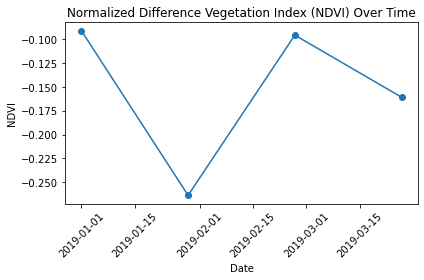

[-0.09131567, -0.2635327, -0.09604259, -0.16095191, nan, nan, nan, nan, nan, nan, nan, nan]


In [1]:
# Importing Necessary Modules
import os
import json
import numpy as np
import rasterio
from datetime import datetime
import matplotlib.pyplot as plt
from rasterio.transform import Affine
from sentinelhub import (
    SHConfig, 
    BBox,
    CRS,
    DataCollection,
    SentinelHubRequest,
    MimeType,
    bbox_to_dimensions,
    SentinelHubDownloadClient,
)

# Set Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'a227b581-ace8-41af-94fe-f4dcf55a5489'  # Fill in your client ID
config.sh_client_secret = 'qR6dwvZE6nnmWewpsW6fQaoeDjxkRyFb'  # Fill in your client secret

# Set AOI, bounding box, and size from GeoJSON object

# GeoJSON object
geojson_str = '''
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -1.8244056385846648,
              5.685847612241702
            ],
            [
              -1.8244056385846648,
              5.582081946896622
            ],
            [
              -1.7306442406759572,
              5.582081946896622
            ],
            [
              -1.7306442406759572,
              5.685847612241702
            ],
            [
              -1.8244056385846648,
              5.685847612241702
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
'''

# Parse GeoJSON string
geojson_data = json.loads(geojson_str)

# Extract coordinates of the polygon
coordinates = geojson_data['features'][0]['geometry']['coordinates'][0]

# Find minimum and maximum longitude and latitude values
min_lon = min(coord[0] for coord in coordinates)
max_lon = max(coord[0] for coord in coordinates)
min_lat = min(coord[1] for coord in coordinates)
max_lat = max(coord[1] for coord in coordinates)

# Create bounding box
bbox_coords = (min_lon, min_lat, max_lon, max_lat)
bbox_obj = BBox(bbox=bbox_coords, crs=CRS.WGS84)
dwn_size = bbox_to_dimensions(bbox_obj, resolution=60)
print("Bounding box:", bbox_coords)

# Set Output Folder Name
output_folder = 'out_dir'

# Function to download Sentinel satellite images
def download_images1(time_interval, cloud_cover=10, resolution=60, satellite='SENTINEL_2A'):
    try: 
        return SentinelHubRequest(
            evalscript='''//VERSION=3
                function setup() {
                    return {
                        input: ["B02", "B03", "B04", "B08"],
                        output: { bands: 4 }
                    };
                }

                function evaluatePixel(sample) {
                    return [ sample.B08, sample.B04, sample.B03, sample.B02 ];
                }
            ''',
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    other_args={
                        "dataFilter": {         
                        'maxCloudCoverage': cloud_cover,
                        'resolution': '60m',
                        'satellite': satellite
                        }
                    }
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=bbox_obj,
            size=dwn_size,
            config=config
        ).get_data()[0]
    except Exception as e:
        print(f"Error occurred while making the API request: {e}")
        return None

# Function to calculate NDVI statistics
def calculate_ndvi_stats1(image_path):
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('f4')
        nir = src.read(4).astype('f4')

    ndvi = (nir - red) / (nir + red)
    ndvi_mean = np.nanmean(ndvi)
    ndvi_median = np.nanmedian(ndvi)
    ndvi_max = np.nanmax(ndvi)
    ndvi_min = np.nanmin(ndvi)

    return ndvi_mean, ndvi_median, ndvi_max, ndvi_min

# Function to plot NDVI over time
def plot_ndvi_over_time1(ndvi_stats, dates):
    plt.plot(dates, ndvi_stats, marker='o')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title('Normalized Difference Vegetation Index (NDVI) Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main function
def main1():
    # Set resolution and iteration index
    resolution = 60  
    idx = 0
    
    # Set Time Intervals
    start = datetime(2019, 1, 1)
    end = datetime(2019, 12, 31)
    n_chunks = 13
    tdelta = (end - start) / n_chunks
    edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
    slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Download Images
    data = [download_images1(slot) for slot in slots]
    
    # Check if any request failed
    if any(sentinel_img is None for sentinel_img in data):
        print("Some API requests failed or no images were available. Exiting...")
        return
    
    # Iterate through data and slots to write image data to a geotiff file
    for image_data, slot in zip(data, slots):
        image_filename = f'{slot[0]}_{slot[1]}_{idx}.tif'
        image_filepath = os.path.join(output_folder, image_filename)

        # Write the image data to a GeoTIFF file using rasterio
        try: 
            with rasterio.open(image_filepath, 'w', driver='GTiff', width=image_data.shape[1], height=image_data.shape[0],
                               count=image_data.shape[2], dtype=str(image_data.dtype), crs='EPSG:4326',
                               transform=Affine.translation(bbox_obj.min_x, bbox_obj.max_y) * Affine.scale(resolution, -resolution)) as dst:
                # Write the data from all bands 
                for i in range(image_data.shape[2]):
                    dst.write(image_data[:, :, i], indexes=i+1)
        except Exception as e:
            print(f"Error occurred while creating GeoTIFF file: {e}")
        idx = idx + 1

    # Calculate NDVI statistics
    ndvi_stats = []
    dates = []
    for root, _, files in os.walk(output_folder):
        for file in files:
            if file.endswith('.tif'):
                image_path = os.path.join(root, file)
                ndvi_mean, _, _, _ = calculate_ndvi_stats1(image_path)
                ndvi_stats.append(ndvi_mean)
                dates.append(datetime.strptime(file[:10], '%Y-%m-%d'))

    # Plot NDVI over time
    plot_ndvi_over_time1(ndvi_stats, dates)
    print(ndvi_stats)


main1()